<a href="https://colab.research.google.com/github/MaryEDeignan/NLP_Recipe_Guide/blob/main/Recipe_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About this Notebook
- You will need to change the path to data, the data file is in the Data folder in github
- if you want to try to improve the recipe generation, feel free to increase the number of epochs. Keep in mind that each epoch takes roughly 30-40 minutes to run so it will take a long time to run this section.

## Based on link below:
https://www.kdnuggets.com/2020/07/generating-cooking-recipes-using-tensorflow.html


In [1]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=2cd670a091bedd004f544691976991d507f3d58f92193fab241700ff3bb28996
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
# imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
import platform
import time
import pathlib
import os
import wget
import zipfile
import pandas as pd

from tensorflow import keras
from google.colab import drive

In [3]:
# connect to your google drive, you don't need to change anything here if you are running in collab
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# making sure that we have the right version, we need tensorflow to be the second version (2.__._)
print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.__version__)

Python version: 3.10.12
Tensorflow version: 2.15.0
Keras version: 2.15.0


In [5]:
# Setting the CACHE_DIR variable to the string './tmp', representing the directory path for caching
CACHE_DIR = './tmp'

# Creating the directory specified by CACHE_DIR if it doesn't already exist
pathlib.Path(CACHE_DIR).mkdir(exist_ok=True)

In [6]:
# Verify the contents of the directory
# here you will need to change to the google drive folder that you data is located in
!ls -l '/content/drive/MyDrive/Fall_2023/NLP/Final/'

# Define the path to the zip file
# here you will need to change to the path to your zip file
zip_file_path = '/content/drive/MyDrive/Fall_2023/NLP/Final/recipes_raw.zip'

# Check if the file exists
!ls -l {zip_file_path}

# Define the destination folder for extraction
unzip_destination = '/content/extracted_data/'

# Create the destination folder if it doesn't exist
!mkdir -p {unzip_destination}

# Unzip the file
!unzip -o {zip_file_path} -d {unzip_destination}

total 122598
-rw------- 1 root root   282010 Dec 22 21:32 'Copy of Recipe_Generation.ipynb'
-rw------- 1 root root   467808 Dec 22 04:56  HuggingFaceData-checkpoint.ipynb
-rw------- 1 root root  2855456 Dec 21 21:52  merged_df.csv
-rw------- 1 root root  2634942 Dec 21 21:52  merged_df_featured.csv
-rw------- 1 root root   284078 Dec 22 20:45  Recipe_Generation.ipynb
-rw------- 1 root root 65658940 Dec 22 20:37  recipe_generation_rnn_raw.h5
-rw------- 1 root root 53355492 Dec 21 19:04  recipes_raw.zip
-rw------- 1 root root 53355492 Dec 21 19:04 /content/drive/MyDrive/Fall_2023/NLP/Final/recipes_raw.zip
Archive:  /content/drive/MyDrive/Fall_2023/NLP/Final/recipes_raw.zip
  inflating: /content/extracted_data/recipes_raw_nosource_ar.json  
  inflating: /content/extracted_data/recipes_raw_nosource_epi.json  
  inflating: /content/extracted_data/recipes_raw_nosource_fn.json  
  inflating: /content/extracted_data/LICENSE  


In [7]:
# Defining a function named 'load_dataset' with optional 'silent' parameter to control printing output
def load_dataset(silent=False):
    # List of dataset files we want to merge
    dataset_file_names = [
        'recipes_raw_nosource_ar.json',
        'recipes_raw_nosource_epi.json',
        'recipes_raw_nosource_fn.json',
    ]
    # Initializing an empty list to store the combined dataset
    dataset = []

    # Iterating through each dataset file name
    for dataset_file_name in dataset_file_names:
        # Constructing the full path to the dataset file
        dataset_file_path = os.path.join('/content/extracted_data', dataset_file_name)

      # Opening the dataset file and loading its content into a dictionary using the json module
        with open(dataset_file_path) as dataset_file:
            json_data_dict = json.load(dataset_file)
            # Extracting a list of values (individual recipes) from the dictionary
            json_data_list = list(json_data_dict.values())
            # Extracting and sorting the keys of the first recipe in the list
            dict_keys = [key for key in json_data_list[0]]
            dict_keys.sort()
            # Adding the recipes to the dataset list
            dataset += json_data_list

            # This code block outputs the summary for each dataset
            if not silent:
                print(dataset_file_path)
                print('===========================================')
                print('Number of examples: ', len(json_data_list), '\n')
                print('Example object keys:\n', dict_keys, '\n')
                print('Example object:\n', json_data_list[0], '\n')
                print('Required keys:\n')
                print('  title: ', json_data_list[0]['title'], '\n')
                print('  ingredients: ', json_data_list[0]['ingredients'], '\n')
                print('  instructions: ', json_data_list[0]['instructions'])
                print('\n\n')
    # Returning the combined dataset
    return dataset

# Calling the 'load_dataset' function to load and merge the specified dataset files, resulting dataset is assigned to the variable 'dataset_raw'
dataset_raw = load_dataset()

/content/extracted_data/recipes_raw_nosource_ar.json
Number of examples:  39802 

Example object keys:
 ['ingredients', 'instructions', 'picture_link', 'title'] 

Example object:
 {'title': 'Slow Cooker Chicken and Dumplings', 'ingredients': ['4 skinless, boneless chicken breast halves ADVERTISEMENT', '2 tablespoons butter ADVERTISEMENT', '2 (10.75 ounce) cans condensed cream of chicken soup ADVERTISEMENT', '1 onion, finely diced ADVERTISEMENT', '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces ADVERTISEMENT', 'ADVERTISEMENT'], 'instructions': 'Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n', 'picture_link': '55lznCYBbs2mT8BTx6BTkLhynGHzM.S'} 

Required keys:

  title:  Slow Cooker Chicken and Dumplings 

  ingredients:  ['4 skinless, bonele

In [ ]:
# Printing the total number of examples in the 'dataset_raw' list to see how many recipes we have
print('Total number of raw examples: ', len(dataset_raw))

Total number of raw examples:  125164


In [8]:
# Defining a function named 'recipe_validate_required_fields' to validate if a recipe contains required fields
def recipe_validate_required_fields(recipe):
    # List of keys that are required for a recipe to be considered valid
    required_keys = ['title', 'ingredients', 'instructions']

    # If the recipe is empty or None, it is considered invalid
    if not recipe:
        return False

    # Iterating through each required key
    for required_key in required_keys:
        # If the value for the required key is empty or None, the recipe is considered invalid
        if not recipe[required_key]:
            return False

        # If the value for the required key is a list and it's empty, the recipe is considered invalid
        if type(recipe[required_key]) == list and len(recipe[required_key]) == 0:
            return False
    # If all required fields are present and non-empty, the recipe is considered valid
    return True

In [9]:
# Filtering the 'dataset_raw' to include only recipes that pass the validation using the 'recipe_validate_required_fields' function
dataset_validated = [recipe for recipe in dataset_raw if recipe_validate_required_fields(recipe)]

# Printing the sizes of the dataset before and after the validation so we can see how many were removed
print('Dataset size BEFORE validation', len(dataset_raw))
print('Dataset size AFTER validation', len(dataset_validated))

Dataset size BEFORE validation 125164
Dataset size AFTER validation 122938


In [10]:
# Defining the stop words for processing and formatting recipes
STOP_WORD_TITLE = '???? '
STOP_WORD_INGREDIENTS = '\n????\n\n'
STOP_WORD_INSTRUCTIONS = '\n????\n\n'

# Defining a function named 'recipe_to_string' to convert a recipe dictionary into a formatted string
def recipe_to_string(recipe):
    # String to be removed from ingredients and instructions (cleaning up noise)
    noize_string = 'ADVERTISEMENT'

    # Extracting title, ingredients, and instructions from the recipe dictionary
    title = recipe['title']
    ingredients = recipe['ingredients']
    instructions = recipe['instructions'].split('\n')

    # Creating a formatted string for ingredients
    ingredients_string = ''
    for ingredient in ingredients:
        ingredient = ingredient.replace(noize_string, '')
        if ingredient:
            ingredients_string += f'• {ingredient}\n'

    # Creating a formatted string for instructions
    instructions_string = ''
    for instruction in instructions:
        instruction = instruction.replace(noize_string, '')
        if instruction:
            instructions_string += f'▪︎ {instruction}\n'

    # Combining the formatted title, ingredients, and instructions into a single string
    return f'{STOP_WORD_TITLE}{title}\n{STOP_WORD_INGREDIENTS}{ingredients_string}{STOP_WORD_INSTRUCTIONS}{instructions_string}'

In [11]:
# Converting each validated recipe in 'dataset_validated' to a formatted string using the 'recipe_to_string' function
dataset_stringified = [recipe_to_string(recipe) for recipe in dataset_validated]

# Checking the size of the stringified dataset
print('Stringified dataset size: ', len(dataset_stringified))

Stringified dataset size:  122938


In [12]:
# Iterating through the first three recipes in the stringified dataset and printing them to see how they look
for recipe_index, recipe_string in enumerate(dataset_stringified[:3]):
    print('Recipe #{}\n---------'.format(recipe_index + 1))
    print(recipe_string)
    print('\n')

Recipe #1
---------
???? Slow Cooker Chicken and Dumplings

????

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

????

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.



Recipe #2
---------
???? Awesome Slow Cooker Pot Roast

????

• 2 (10.75 ounce) cans condensed cream of mushroom soup 
• 1 (1 ounce) package dry onion soup mix 
• 1 1/4 cups water 
• 5 1/2 pounds pot roast 

????

▪︎ In a slow cooker, mix cream of mushroom soup, dry onion soup mix and water. Place pot roast in slow cooker and coat with soup mixture.
▪︎ Cook on High setting for 3 to 4 hours, or on Low setting for 8 to 9

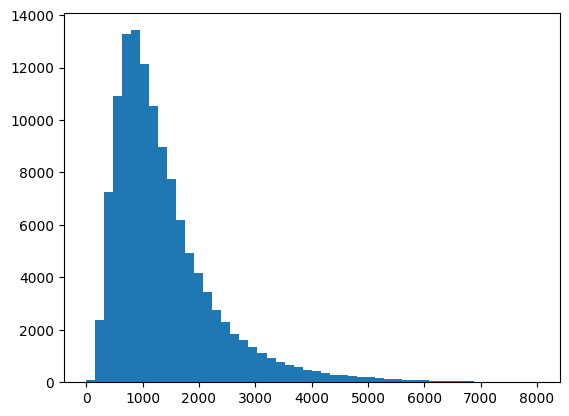

In [13]:
# Calculating the lengths of each recipe in the stringified dataset and creating a histogram
recipes_lengths = []
for recipe_text in dataset_stringified:
    recipes_lengths.append(len(recipe_text))

# Creating a histogram of recipe lengths to see where an appropriate cut off might be
plt.hist(recipes_lengths, range=(0, 8000), bins=50)
plt.show()

In [14]:
# Defining the maximum allowed length for recipes based on histogram above
MAX_RECIPE_LENGTH = 2000

# Defining a function named 'filter_recipes_by_length' to filter recipes based on their length
def filter_recipes_by_length(recipe_test):
    return len(recipe_test) <= MAX_RECIPE_LENGTH

# Filtering recipes in 'dataset_stringified' based on the specified maximum length using the 'filter_recipes_by_length' function
dataset_filtered = [recipe_text for recipe_text in dataset_stringified if filter_recipes_by_length(recipe_text)]

# Checking the sizes of the dataset before and after filtering
print('Dataset size BEFORE filtering: ', len(dataset_stringified))
print('Dataset size AFTER filtering: ', len(dataset_filtered))

Dataset size BEFORE filtering:  122938
Dataset size AFTER filtering:  100001


In [15]:
# Assigning the total number of recipes after filtering to the variable 'TOTAL_RECIPES_NUM'
TOTAL_RECIPES_NUM = len(dataset_filtered)

# checking that filtering above worked
print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)

MAX_RECIPE_LENGTH:  2000
TOTAL_RECIPES_NUM:  100001


In [16]:
# Defining a stop sign to be used in tokenization
STOP_SIGN = '␣'

# Initializing a Tokenizer with specified parameters
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,  # Tokenizing at the character level
    filters='',  # No characters to be filtered
    lower=False,  # Keeping the case of characters as is
    split=''  # Splitting at the character level
)

# Fitting the tokenizer on the stop sign to ensure it is recognized during tokenization
tokenizer.fit_on_texts([STOP_SIGN])

# Fitting the tokenizer on the filtered dataset to learn the vocabulary
tokenizer.fit_on_texts(dataset_filtered)

# Getting the configuration of the tokenizer
tokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': '',
 'char_level': True,
 'oov_token': None,
 'document_count': 100002,
 'word_counts': '{"\\u2423": 1, "?": 1200337, " ": 17456341, "S": 269334, "l": 3799351, "o": 5962595, "w": 960376, "C": 222127, "k": 887422, "e": 9257735, "r": 4741353, "h": 2908968, "i": 4891153, "c": 2872419, "n": 5282692, "a": 6042166, "d": 3086749, "D": 63726, "u": 2706138, "m": 1786991, "p": 2668709, "g": 1691743, "s": 4684699, "\\n": 1949725, "\\u2022": 919860, "4": 231801, ",": 1125887, "b": 1388955, "t": 5971681, "v": 743650, "2": 492133, "(": 144468, "1": 851115, "0": 144643, ".": 1048251, "7": 31019, "5": 153573, ")": 144461, "f": 1038022, "y": 663513, "\\u25aa": 329932, "\\ufe0e": 329932, "P": 199874, "6": 51190, "H": 43774, "A": 133626, "3": 212769, "R": 100857, "x": 200639, "/": 344177, "I": 81359, "L": 45967, "8": 55146, "9": 17642, "B": 123389, "M": 78391, "F": 103981, "j": 109527, "-": 218143, "W": 61318, "\\u00ae": 10151, "N": 12762, "q

In [17]:
# Calculating the vocabulary size based on the word counts obtained from the tokenizer
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1

# Printing the calculated vocabulary size
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  173


In [18]:
# Converting sequences of word indices back to text using the tokenizer's sequences_to_texts method
array_vocabulary = tokenizer.sequences_to_texts([[word_index] for word_index in range(VOCABULARY_SIZE)])

# Printing the array of characters in the vocabulary
print([char for char in array_vocabulary])

['', ' ', 'e', 'a', 't', 'o', 'n', 'i', 'r', 's', 'l', 'd', 'h', 'c', 'u', 'p', '\n', 'm', 'g', 'b', '?', ',', '.', 'f', 'w', '•', 'k', '1', 'v', 'y', '2', '/', '▪', '︎', 'S', '4', 'C', '-', '3', 'x', 'P', '5', '0', '(', ')', 'A', 'B', 'z', 'j', 'F', 'T', 'R', 'I', 'M', ';', 'q', 'D', 'W', '8', 'G', '6', 'L', 'H', ':', '7', 'O', "'", 'E', 'K', '9', 'U', 'N', 'V', 'J', '®', '°', 'é', '"', 'Y', 'Q', '*', '!', 'Z', '–', '&', '%', 'ñ', 'è', '™', 'î', 'X', '¿', '—', 'ç', '#', '½', 'í', '=', '’', 'â', '©', '¼', '+', '>', '$', '<', 'ó', 'á', 'ú', 'ï', 'É', 'û', ']', '[', 'ü', 'ê', '_', '\xad', 'à', '¾', '‚', '�', 'º', '⁄', 'ä', 'Ú', 'ù', '́', '}', 'ö', '{', 'ì', 'ô', '\x96', '”', '×', '˚', '»', '@', '§', '\\', '◊', '‱', '“', '‧', '\u202d', '⅛', 'å', 'ﬂ', '`', 'ë', '\x97', '\x1a', 'ø', '⅓', '|', 'ư', '\x92', '´', '‒', 'Â', '␣', 'Á', '¤', '‟', '\xa0', 'ơ', 'ă', '̀', '⅞', '€', '~', '\x95']


In [19]:
# Converting a text sequence containing the stop word '???? yes' into a sequence of word indices using the tokenizer
tokenizer.texts_to_sequences(['???? yes'])

[[20, 20, 20, 20, 1, 29, 2, 9]]

In [20]:
# Converting the filtered dataset of stringified recipes into sequences of word indices using the tokenizer
dataset_vectorized = tokenizer.texts_to_sequences(dataset_filtered)

# Printing the size of the vectorized dataset
print('Vectorized dataset size', len(dataset_vectorized))

Vectorized dataset size 100001


In [21]:
# Defining a function named 'recipe_sequence_to_string' to convert a recipe sequence back into a string
def recipe_sequence_to_string(recipe_sequence):
    # Converting the recipe sequence into a string using the tokenizer's sequences_to_texts method.
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    print(recipe_stringified)

# Calling the function with the first recipe sequence in the vectorized dataset
recipe_sequence_to_string(dataset_vectorized[0])

? ? ? ?   S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s 
 
 ? ? ? ? 
 
 •   4   s k i n l e s s ,   b o n e l e s s   c h i c k e n   b r e a s t   h a l v e s   
 •   2   t a b l e s p o o n s   b u t t e r   
 •   2   ( 1 0 . 7 5   o u n c e )   c a n s   c o n d e n s e d   c r e a m   o f   c h i c k e n   s o u p   
 •   1   o n i o n ,   f i n e l y   d i c e d   
 •   2   ( 1 0   o u n c e )   p a c k a g e s   r e f r i g e r a t e d   b i s c u i t   d o u g h ,   t o r n   i n t o   p i e c e s   
 
 ? ? ? ? 
 
 ▪ ︎   P l a c e   t h e   c h i c k e n ,   b u t t e r ,   s o u p ,   a n d   o n i o n   i n   a   s l o w   c o o k e r ,   a n d   f i l l   w i t h   e n o u g h   w a t e r   t o   c o v e r . 
 ▪ ︎   C o v e r ,   a n d   c o o k   f o r   5   t o   6   h o u r s   o n   H i g h .   A b o u t   3 0   m i n u t e s   b e f o r e   s e r v i n g ,   p l a c e   t h e   t o r n   b i s c u i t   d o u g h   i n   t h e   s l o w   c o o k e r 

In [22]:
# Iterating through the first ten recipes in the vectorized dataset and printing their lengths
for recipe_index, recipe in enumerate(dataset_vectorized[:10]):
    print('Recipe #{} length: {}'.format(recipe_index + 1, len(recipe)))

Recipe #1 length: 555
Recipe #2 length: 410
Recipe #3 length: 680
Recipe #4 length: 745
Recipe #5 length: 1527
Recipe #6 length: 749
Recipe #7 length: 848
Recipe #8 length: 676
Recipe #9 length: 1273
Recipe #10 length: 863


In [23]:
# Padding the vectorized dataset without stop signs to ensure uniform length for model input
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    # Using -1 here and +1 in the next step to ensure each sequence has at least 1 stop sign at the end
    maxlen=MAX_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

# Padding the vectorized dataset with stop signs for model input
dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)
# Printing the lengths of the first ten recipes in the padded vectorized dataset to make sure they are the same
for recipe_index, recipe in enumerate(dataset_vectorized_padded[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

Recipe #0 length: 2001
Recipe #1 length: 2001
Recipe #2 length: 2001
Recipe #3 length: 2001
Recipe #4 length: 2001
Recipe #5 length: 2001
Recipe #6 length: 2001
Recipe #7 length: 2001
Recipe #8 length: 2001
Recipe #9 length: 2001


In [24]:
# Calling the 'recipe_sequence_to_string' function with the first padded and vectorized recipe sequence
recipe_sequence_to_string(dataset_vectorized_padded[0])

? ? ? ?   S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s 
 
 ? ? ? ? 
 
 •   4   s k i n l e s s ,   b o n e l e s s   c h i c k e n   b r e a s t   h a l v e s   
 •   2   t a b l e s p o o n s   b u t t e r   
 •   2   ( 1 0 . 7 5   o u n c e )   c a n s   c o n d e n s e d   c r e a m   o f   c h i c k e n   s o u p   
 •   1   o n i o n ,   f i n e l y   d i c e d   
 •   2   ( 1 0   o u n c e )   p a c k a g e s   r e f r i g e r a t e d   b i s c u i t   d o u g h ,   t o r n   i n t o   p i e c e s   
 
 ? ? ? ? 
 
 ▪ ︎   P l a c e   t h e   c h i c k e n ,   b u t t e r ,   s o u p ,   a n d   o n i o n   i n   a   s l o w   c o o k e r ,   a n d   f i l l   w i t h   e n o u g h   w a t e r   t o   c o v e r . 
 ▪ ︎   C o v e r ,   a n d   c o o k   f o r   5   t o   6   h o u r s   o n   H i g h .   A b o u t   3 0   m i n u t e s   b e f o r e   s e r v i n g ,   p l a c e   t h e   t o r n   b i s c u i t   d o u g h   i n   t h e   s l o w   c o o k e r 

In [25]:
# Creating a TensorFlow dataset from the padded and vectorized recipe sequences
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

In [26]:
# Iterating through one batch of the dataset and printing the raw and stringified recipe sequences
for recipe in dataset.take(1):
    print('Raw recipe:\n', recipe.numpy(), '\n\n\n')
    print('Stringified recipe:\n')
    recipe_sequence_to_string(recipe.numpy())

Raw recipe:
 [ 20  20  20 ... 161 161 161] 



Stringified recipe:

? ? ? ?   S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s 
 
 ? ? ? ? 
 
 •   4   s k i n l e s s ,   b o n e l e s s   c h i c k e n   b r e a s t   h a l v e s   
 •   2   t a b l e s p o o n s   b u t t e r   
 •   2   ( 1 0 . 7 5   o u n c e )   c a n s   c o n d e n s e d   c r e a m   o f   c h i c k e n   s o u p   
 •   1   o n i o n ,   f i n e l y   d i c e d   
 •   2   ( 1 0   o u n c e )   p a c k a g e s   r e f r i g e r a t e d   b i s c u i t   d o u g h ,   t o r n   i n t o   p i e c e s   
 
 ? ? ? ? 
 
 ▪ ︎   P l a c e   t h e   c h i c k e n ,   b u t t e r ,   s o u p ,   a n d   o n i o n   i n   a   s l o w   c o o k e r ,   a n d   f i l l   w i t h   e n o u g h   w a t e r   t o   c o v e r . 
 ▪ ︎   C o v e r ,   a n d   c o o k   f o r   5   t o   6   h o u r s   o n   H i g h .   A b o u t   3 0   m i n u t e s   b e f o r e   s e r v i n g ,   p l a c e   t h e   t o r 

In [27]:
# Defining a function named 'split_input_target' to split a recipe sequence into input and target sequences
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]

    return input_text, target_text

# Mapping the 'split_input_target' function to the dataset to create input-target pairs
dataset_targeted = dataset.map(split_input_target)

In [28]:
# Iterating through one batch of the targeted dataset and printing information about the input and target sequences
for input_example, target_example in dataset_targeted.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()

    # Converting a subset of the input and target sequences into string for display
    input_stringified = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_stringified = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]

    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified)))

Input sequence size: 2000
Target sequence size: 2000

Input:   '? ? ? ?   S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s \n \n ? ? ? ? \n \n •   4  '
Target:  '? ? ?   S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s \n \n ? ? ? ? \n \n •   4   s'


In [29]:
# Iterating through the first ten steps of the input and target sequences and printing their indices and string representations
for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
    print('Step {:2d}'.format(i + 1))
    print('  input: {} ({:s})'.format(input_idx, repr(tokenizer.sequences_to_texts([[input_idx.numpy()]])[0])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(tokenizer.sequences_to_texts([[target_idx.numpy()]])[0])))

Step  1
  input: 20 ('?')
  expected output: 20 ('?')
Step  2
  input: 20 ('?')
  expected output: 20 ('?')
Step  3
  input: 20 ('?')
  expected output: 20 ('?')
Step  4
  input: 20 ('?')
  expected output: 1 (' ')
Step  5
  input: 1 (' ')
  expected output: 34 ('S')
Step  6
  input: 34 ('S')
  expected output: 10 ('l')
Step  7
  input: 10 ('l')
  expected output: 5 ('o')
Step  8
  input: 5 ('o')
  expected output: 24 ('w')
Step  9
  input: 24 ('w')
  expected output: 1 (' ')
Step 10
  input: 1 (' ')
  expected output: 36 ('C')


In [30]:
# Defining the batch size for training
BATCH_SIZE = 64

# Defining the buffer size for shuffling the dataset
#(TF data is designed to work with possibly infinite sequences, so it doesn't attempt to shuffle the entire sequence in memory. Instead, it maintains a buffer in which it shuffles elements)
SHUFFLE_BUFFER_SIZE = 1000

# Creating a training dataset by shuffling and batching the targeted dataset
# The 'drop_remainder=True' argument ensures that any remaining examples that don't fit into a full batch are discarded
dataset_train = dataset_targeted.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat()

In [31]:
# Iterating through the first batch of the training dataset and printing the input and target text sequences
for input_text, target_text in dataset_train.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[ 20  20  20 ... 161 161 161]
 [ 20  20  20 ... 161 161 161]
 [ 20  20  20 ... 161 161 161]
 ...
 [ 20  20  20 ... 161 161 161]
 [ 20  20  20 ... 161 161 161]
 [ 20  20  20 ... 161 161 161]], shape=(64, 2000), dtype=int32)

1st batch: target_text: tf.Tensor(
[[ 20  20  20 ... 161 161 161]
 [ 20  20  20 ... 161 161 161]
 [ 20  20  20 ... 161 161 161]
 ...
 [ 20  20  20 ... 161 161 161]
 [ 20  20  20 ... 161 161 161]
 [ 20  20  20 ... 161 161 161]], shape=(64, 2000), dtype=int32)


In [32]:
# Defining temporary parameters for the embedding layer and model
tmp_vocab_size = 10
tmp_embedding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

# Creating a Sequential model and adding an Embedding layer
tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embedding_size,
  input_length=tmp_input_length
))

# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.

# Generating a random input array for testing
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)

# Compiling the model with 'rmsprop' optimizer and 'mse' loss
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

# Printing information about the input and output arrays
print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

1/1 [==============================] - 0s 95ms/step
tmp_input_array shape: (2, 8)
tmp_input_array:
[[4 5 1 8 9 2 6 4]
 [5 6 3 2 3 6 5 3]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[ 0.01075137 -0.0448327   0.03520346  0.02052024  0.02557049]
  [-0.03446863 -0.04412745  0.03929839  0.01546976 -0.00396204]
  [ 0.04376331  0.00863398  0.03915283 -0.02966436  0.00066907]
  [-0.04373101 -0.03871477  0.03881938  0.02781203 -0.03971809]
  [-0.01957703  0.02589533  0.02159623 -0.04574908 -0.02830471]
  [-0.00516249  0.04789433 -0.03023021  0.03897375  0.02091254]
  [ 0.01167031 -0.01919737  0.00316072 -0.01025742  0.0330268 ]
  [ 0.01075137 -0.0448327   0.03520346  0.02052024  0.02557049]]

 [[-0.03446863 -0.04412745  0.03929839  0.01546976 -0.00396204]
  [ 0.01167031 -0.01919737  0.00316072 -0.01025742  0.0330268 ]
  [-0.0382445   0.0176493  -0.04462053  0.02893532  0.00883055]
  [-0.00516249  0.04789433 -0.03023021  0.03897375  0.02091254]
  [-0.0382445   0.0176493  -0.04462053 

In [33]:
# Defining a function named 'build_model' to create a language model with an Embedding layer, LSTM layer, and Dense layer
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    # Adding an Embedding layer with specified vocab_size, embedding_dim, and batch_input_shape
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    # Adding an LSTM layer with specified units, return_sequences, stateful, and recurrent_initializer parameters
    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    # Adding a Dense layer with output size equal to the vocabulary size
    model.add(tf.keras.layers.Dense(vocab_size))

    return model

# Building a model with specified parameters
model = build_model(
  vocab_size=VOCABULARY_SIZE,
  embedding_dim=256,
  rnn_units=1024,
  batch_size=BATCH_SIZE
)

# Displaying the summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (64, None, 256)           44288     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 173)           177325    
                                                                 
Total params: 5468589 (20.86 MB)
Trainable params: 5468589 (20.86 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
# Iterating through one batch of the training dataset and printing the shape of the model predictions
for input_example_batch, target_example_batch in dataset_train.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 2000, 173) # (batch_size, sequence_length, vocab_size)


In [35]:
# Defining a 2-D Tensor 'tmp_logits' with shape [batch_size, num_classes]
# Each slice [i, :] represents the unnormalized log-probabilities for all classes
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Generating 5 samples using the tf.random.categorical function
# Each sample is a class index, and class probabilities are taken into account
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

# Printing the generated samples
print(tmp_samples)

tf.Tensor([[2 1 1 1 1]], shape=(1, 5), dtype=int64)


In [36]:
# Generating sampled indices from the model predictions for the first example in the batch
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

# Squeezing the sampled indices along the last axis and converting to a NumPy array
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

# Printing the shape of the sampled indices
sampled_indices.shape

(2000,)

In [37]:
# Printing the first 100 sampled indices from the generated sequence
sampled_indices[:100]

array([ 18,  56,  33,  73, 135,  88,  63, 101, 114,  98, 151, 105, 127,
       159,  16,  18,  55, 116, 129,  81,  67,   6,  61, 160, 100,  12,
        66, 139, 140,  17,  39, 127, 104,  98, 119, 103,  33, 103, 157,
       169,  44,  44, 104,  20,  95,  91,  71, 159,  70,  84, 151,  61,
        50,  63,  55, 141,  84, 111,  35,  28,  38,   3,  96,  35,  95,
       137,  55, 115, 143,  27,  76,  97, 103,  52, 130,  65, 154, 114,
        72,  97, 151, 105,  13, 105,  19, 150,  84, 132,  13, 160,  52,
       135, 112,  26,  78,  81, 109,  46,  63,  66])

In [38]:
# Defining a custom loss function named 'loss', function is any callable with the signature scalar_loss = fn(y_true, y_pred)

def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

    return entropy

# Calculating the loss for the example batch
example_batch_loss = loss(target_example_batch, example_batch_predictions)

# Printing information about the prediction shape and the calculated scalar loss.
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss.shape:      ", example_batch_loss.shape)
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 2000, 173)  # (batch_size, sequence_length, vocab_size)
scalar_loss.shape:       (64, 2000)
scalar_loss:       5.150636


In [39]:
# Defining the Adam optimizer with a learning rate of 0.001
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compiling the model with the Adam optimizer and the custom 'loss' function
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

In [40]:
# Defining an EarlyStopping callback to monitor the 'loss' metric and restore the best weights
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [41]:
# Create a checkpoints directory
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Defining a checkpoint prefix for the model checkpoint callback
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

# Creating a ModelCheckpoint callback to save model weights at each epoch.
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [42]:
# Setting the number of epochs, initial epoch, and steps per epoch for training
EPOCHS = 5
INITIAL_EPOCH = 1
STEPS_PER_EPOCH = 1500

In [46]:
# Training the model on the training dataset with specified parameters and callbacks
history = model.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback
    ]
)

# Saving the trained model to file (to be able to re-use it later).
model_name = 'recipe_generation_rnn_raw.h5'
model.save(model_name, save_format='h5')

Epoch 2/5
1500/1500 [==============================] - 2197s 1s/step - loss: 0.6512
Epoch 3/5
1500/1500 [==============================] - 2200s 1s/step - loss: 0.3534
Epoch 4/5
1500/1500 [==============================] - 2204s 1s/step - loss: 0.3133
Epoch 5/5
1500/1500 [==============================] - 2205s 1s/step - loss: 0.2920


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
# Set path where you want to save the model
drive_model_path = '/content/drive/MyDrive/Fall_2023/NLP/Final/recipe_generation_rnn_raw.h5'

# Move the model file to Google Drive
!mv {model_name} {drive_model_path}

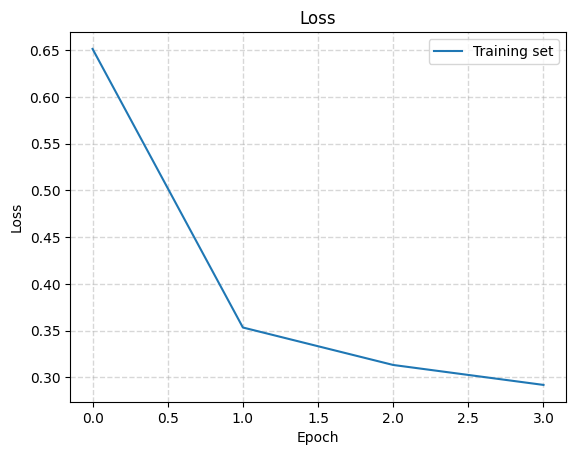

In [48]:
# Defining a function named 'render_training_history' to visualize the training loss over epochs
def render_training_history(training_history):
    loss = training_history.history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

# Calling the function with the training history to visualize the loss
render_training_history(history)

In [49]:
# Getting the latest checkpoint file in the specified directory
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints/ckpt_5'

In [50]:
# Setting the embedding dimension and the number of units in the LSTM layer
embedding_dim=256
rnn_units=1024

In [51]:
# Defining a simplified batch size for model loading and inference
simplified_batch_size = 1

# Building a simplified model using the same architecture as the original model
model_simplified = build_model(VOCABULARY_SIZE, embedding_dim, rnn_units, simplified_batch_size)
# Loading the weights from the latest checkpoint
model_simplified.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
# Building the model with a specific batch size
model_simplified.build(tf.TensorShape([simplified_batch_size, None]))

# Displaying the summary of the simplified model
model_simplified.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (1, None, 256)            44288     
                                                                 
 lstm_2 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_2 (Dense)             (1, None, 173)            177325    
                                                                 
Total params: 5468589 (20.86 MB)
Trainable params: 5468589 (20.86 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Printing the input shape of the simplified model
model_simplified.input_shape

(1, None)

In [ ]:
# Defining a function named 'generate_text' to generate text using the trained model
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    padded_start_string = STOP_WORD_TITLE + start_string

    # Converting our start string to numbers (vectorizing)
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))

    # Empty string to store our results
    text_generated = []

    # Here batch size == 1
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1, 0].numpy()

        # We pass the predicted character as the next input to the model along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]

        text_generated.append(next_character)

    return (padded_start_string + ''.join(text_generated))

In [ ]:
# Defining a function named 'generate_combinations' to generate text combinations using the trained model
def generate_combinations(model):
    # Setting the desired recipe length for each generated text
    recipe_length = 1000
    # Specifying a list of starting letters and temperatures to try
    try_letters = ['', '\n', 'A', 'B', 'C', 'O', 'L', 'Mushroom', 'Apple', 'Slow', 'Christmass', 'The', 'Banana', 'Homemade']
    try_temperature = [1.0, 0.8, 0.4, 0.2]

    # Iterating over each combination of starting letter and temperature
    for letter in try_letters:
        for temperature in try_temperature:
            # Generating text using the trained model with the specified parameters.
            generated_text = generate_text(
                model,
                start_string=letter,
                num_generate = recipe_length,
                temperature=temperature
            )
            # Printing the details of the attempt
            print(f'Attempt: "{letter}" + {temperature}')
            print('-----------------------------------')
            # Printing the generated text
            print(generated_text)
            print('\n\n')

In [ ]:
# Generating text combinations using the simplified model
generate_combinations(model_simplified)

Attempt: "" + 1.0
-----------------------------------
???? Â@ô»>Y5GôÚÁQ'Q▪è4ñZî”KXE+8|7▪▪9•¼å½JG⁄™K“Â8•§#'ø#‧$øơ_á7▪Éî#éVï-`{ë́•Y´í9X▪:íÉ%3•Q–ư”XL
jë<ơ×8E~YZñ́ëñW“+{‱K{]—­ưîÉ9½ º¿â©åêă‒#¤’®$º�AéE9G˚E§EAùWKí¿;àN™é7•3▪94▪7‧▪7º9]9ﬂVºì®́â︎#ï¿®ä︎”áúYîíïÚ”%B$ë7‚à3▪!§X▪í8▪5▪7▪4▪9▪øâ▪W5óÚ€�`®3Oé‚~_—“í%4Oé©ñ5#x▪óY¾ú⅓X‚Z`©‚èèÉÂ•4Ek®è7âà▪W‟ºAY´ëÉÁ“C$é(ﬂơ5E4CK�ﬂé7é�­'öèOGñ´í¿ÁêE{¾E2ô½#'§ZJ\#_¤YN⅞ù´#§X#Á»_︎Bå‱Z9▪$¤&­—å▪•ó5▪3▪V3▪T¼︎Y◊§#́5▪7ơE▪KJ` °⁄⅛î§áºQﬂ9•9▪ﬂ|§àâ>QÁó9‒ÚQ◊J>‚3▪▪%3EE6>ï{�Qñö¾E~éDQ‚îY`@®–ﬂ©éEé¼´5EYơ¤︎Q‭óEWT⅛‱ø0̀áEí€#f▪▪¾ù×àE#Ú5•¼5▪úZ½#•UDä•5EZG8EEá’è#}äQ Ú– ︎9E˚KHăJÂ®5E6▪‟É>ÁçÉ|$â#íÁGç‧î]áÁ#{$◊0E'@ZÚâXÉf‧!óZ’3▪‒8Yﬂåñà’è>§7▪2 0ZÉ8Yç︎í0}‒KX˚ÂZ⅓ö“É⅓Eë\©×Oú5•Eâ-Eâ$éW•́7•Gé~—©‚í®½#|ÉÁU‒#É•íâWû9⅓▪96▪á]˚—E3▪O~5▪•ì¤<‱‒@ëE5▪öÁ́®ñ0Dô#é“<ëﬂ×z©‚N Éñ®‭Qx▪àEEâø5▪HÚQz>G(”Y½EÚXơ7•}™_”“»3Á ´­ç{ơ
|HÉáàD3úVơçYÚYEYZQüèz“\úNàX▪@Mú5▪E%3É8EçEk9áä7ñÉ▪ZT︎Xz`É︎ö́Gî´>̀»Qçó7´°êY¾ñY5ñ⅓Éç9Eá|—ﬂU5JìUEí!3ñ‚X▪½åKìVìé7•îAEí3»óëA▪Qó##ư­»$©î7▪◊€RK®⁄îÉ+âE9▪7Z–%VZ®8™=7óöTöQ︎°É3TÁ´‭9V˚T